In [1]:
import itertools
from itertools import chain
import json
import math
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import random
import time
import typing

plt.rcParams.update({
    "figure.figsize": [20, 10],
    "font.size": 16
})

In [104]:
def cross_validate_function(df: pd.DataFrame, func, **kwargs) -> dict:
    '''returns validation metrics for warm-up creation function. Includes:
    
    n_moves: number of movements passed to func
    t_avg: time taken to create warm-up
    n_warmups: number of valid warm-ups created
    '''
    func_dict = {"n_moves":[], "t_avg":[], "n_warmups": []}
    n_moves = 3
    t_avg = 0
    
    print("[*] func validation started")
    while t_avg <= 5 and n_moves <= 100:
        sub_df = df.iloc[:n_moves].dropna(axis=0, how="all").dropna(axis=1, how="all")
        
        t_s = []
        for _ in range(3):
            try:
                t_init = time.time()
                warmups_created, _ = func(sub_df, **kwargs)
                t_s.append(round(time.time() - t_init, 4))
            except RuntimeError:
                print(f"[*] n_moves = {n_moves} failed.")
                break
                
        if t_s:
            t_avg = round(np.mean(t_s), 4)
            
            func_dict["n_moves"].append(n_moves)
            func_dict["t_avg"].append(t_avg)
            func_dict["n_warmups"].append(warmups_created)

            print(f"[*] n_moves = {n_moves} completed. t_avg = {t_avg}")

        n_moves += 1
            
    print(f"[*] func validation completed")
    
    return func_dict

def get_par_nodes(graph: nx.DiGraph, node: str) -> typing.List[str]:
    '''Returns all parent nodes leading to initial movement'''
    preds = list(graph.predecessors(node))
    return [node] + get_par_nodes(graph, preds[0]) if preds else [node]
    
def remove_warmup_supersets(warmups: typing.List[typing.List[str]]) -> typing.List[typing.List[str]]:
    '''Returns all sublists which are not a subset of any other 
    sublist in warmups'''
    counts = set(map(len, warmups))
    count_dict = {n: [warmup for warmup in warmups if len(warmup) == n] for n in counts}

    for i, j in [(i, j) for i in counts for j in counts if i > j]:
        for lg_warmup in count_dict[i]:
            if lg_warmup in warmups:
                for sm_warmup in count_dict[j]:
                    if set(lg_warmup).issuperset(sm_warmup):
                        warmups.remove(lg_warmup)
                        break
                        
    return warmups

In [88]:
df = pd.read_csv("../tests/test_movement_description.csv")
df = df.dropna(axis=0, how="all").dropna(axis=1, how="all").rename(columns={"Movement": "name"}).set_index("name")

## Create Warm-up Function: Combinations

### Method

* Identify combinations whereby length of subsequences are between `min_moves` and `max_moves` in length 
* Accept combinations for which the row sum has at least 1 in each column
* Remove subsequences which superset other subsequences
* Randomly choose 1 subsequence as the workout suggested

In [89]:
def create_warmup_1(df, min_moves, max_moves):
    perms = chain.from_iterable(itertools.combinations(range(df.shape[0]), i) for i in range(min_moves, max_moves+1))
    
    warmups = []
    for group in perms:
        if df.iloc[list(group), :].sum().all():
            warmups.append(sorted(list(df.index[list(group)])))

    if not warmups:
        raise RuntimeError("No warm-up combinations satisfying min-max conditions")

    warmups = remove_warmup_supersets(warmups)
    warmup = random.choice(warmups)
    
    return len(warmups), warmup

In [90]:
t_init = time.time()
warmups_created, warmup = create_warmup_1(df, 3, 5)
print(warmups_created, ">>", warmup)
print(round(time.time() - t_init, 2))

7 >> ['Calf Raises', 'Lunges', 'Muscle Snatch', 'Power Snatch']
1.05


## Create Warm-up Function: Limited Combinations

### Method

* Identify combinations whereby length of subsequences are between `min_moves` and `max_moves` in length 
* If the number of sequences exceed limit `l`, take an evenly spaced subset of values from the full list
* Accept combinations for which the row sum has at least 1 in each column
* Remove subsequences which superset other subsequences
* Randomly choose 1 subsequence as the workout suggested

In [91]:
def create_warmup_1_lim(df, min_moves, max_moves, max_seqs = 1000):
    perm = chain.from_iterable(itertools.combinations(range(df.shape[0]), i) for i in range(min_moves, max_moves+1))
    n_seq = sum([math.comb(df.shape[0], i) for i in range(min_moves, max_moves+1)])
    
    if n_seq > max_seqs:
        perm = itertools.islice(perm, 0, None, math.ceil(n_seq/max_seqs))

    warmups = []
    for seq in perm:
        if df.iloc[list(seq), :].sum().all():
            warmups.append(sorted(list(df.index[list(seq)])))

    if not warmups:
        raise RuntimeError("No warm-up combinations satisfying min-max conditions")

    warmups = remove_warmup_supersets(warmups)
    warmup = random.choice(warmups)
    
    return len(warmups), warmup

In [92]:
t_init = time.time()
warmups_created, warmup = create_warmup_1_lim(df, 3, 5)
print(warmups_created, ">>", warmup)
print(round(time.time() - t_init, 2))

11 >> ['Calf Raises', 'Lunges', 'Muscle Snatch', 'Push Press', 'Running']
0.54


## Create Warm-up Function: Directed Tree

### Method

* Create directed graph of warmups up to maximum height of `max_moves` - 1:
    * At height -1:
        1. Add all movements as nodes
        
    * Iterative for height `h` in [0, `max_moves` - 1] for node `n_h`:
        1. Identify all movements on path to `n_h`
        2. Create sub-dataframe, remove these movements and the catered movement types from the core dataframe
        3. If the sub-dataframe has no rows or columns, append the movements on the path to the warm-up list
        3. If the sub-dataframe has rows or columns, create edges from node `n_h` to all remaining movements at height `h` + 1
        
    * At height `max_moves`:
        1. Identify all movements on path to `n_h`
        2. Create sub-dataframe, remove these movements and the catered movement types from the core dataframe
        3. If the sub-dataframe has no rows or columns, append the movements on the path to the warm-up list
* Remove duplicates in warm-ups
* Remove subsequences which superset other subsequences in warmups
* Randomly choose 1 subsequence as the warm-up suggested

In [93]:
def create_warmup_2(df, min_moves, max_moves):
    
    graph = nx.DiGraph()
    graph.add_nodes_from(["1_"+move for move in df.index])

    counter = 0
    loop = 2
    updating = True
    warmups = []

    while updating and loop <= max_moves+1:
        updating = False #changed to true during loop if new move added

        for i, leaf in enumerate(list(graph.nodes)[counter:]):
            rows = [node.split("_")[1] for node in get_par_nodes(graph, leaf)]
            cols = df.iloc[0, (df.loc[rows].sum() > 0).values].index
            sub_df = df.drop(index=rows, columns=cols).dropna(axis=0, how="all")

            if sub_df.shape == (0, 0) and len(rows) >= min_moves:
                warmups.append(sorted(rows))

            elif loop != max_moves+1:
                graph.add_edges_from([(leaf, f"{loop}{i}_"+move) for move in sub_df.index])
                updating = True

            counter += 1
        loop += 1
        
    if not warmups:
        raise RuntimeError("No warm-up combinations satisfying min-max conditions")
    
    #remove duplicates and supersets
    warmups.sort()
    warmups = list(warmup for warmup, _ in itertools.groupby(warmups))
    warmups = remove_warmup_supersets(warmups)
    warmup = random.choice(warmups)
    
    return len(warmups), warmup

In [94]:
t_init = time.time()
warmups_created, warmup = create_warmup_2(df, 3, 5)
print(warmups_created, ">>", warmup)
print(round(time.time() - t_init, 2))

7 >> ['Calf Raises', 'Lunges', 'Muscle Snatch', 'Running', 'Strict Press']
56.83


## Create Warm-up Function: Limited Directed Tree

### Method

* Create directed graph of warmups up to maximum height of `max_moves` - 1:
    * At height -1:
        1. Add up to `l` randomly selected movements from all movements as nodes
        
    * Iterative for height `h` in [0, `max_moves` - 1] for node `n_h`:
        1. Identify all movements on path to `n_h`
        2. Create sub-dataframe, remove these movements and the catered movement types from the core dataframe
        3. If the sub-dataframe has no rows or columns, append the movements on the path to the warm-up list
        3. If the sub-dataframe has rows or columns, create edges from node `n_h`for up to `l` randomly selected remaining movements at height `h` + 1
        
    * At height `max_moves`:
        1. Identify all movements on path to `n_h`
        2. Create sub-dataframe, remove these movements and the catered movement types from the core dataframe
        3. If the sub-dataframe has no rows or columns, append the movements on the path to the warm-up list
* Remove duplicates in warm-ups
* Remove subsequences which superset other subsequences in warmups
* Randomly choose 1 subsequence as the warm-up suggested

In [113]:
def create_warmup_2_lim(df, min_moves, max_moves, max_oe=4):
    
    rows = random.sample(list(df.index), max_oe) if df.shape[0] > max_oe else df.index

    graph = nx.DiGraph()
    graph.add_nodes_from(["1_"+move for move in rows])

    counter = 0
    loop = 2
    updating = True
    warmups = []
    
    while updating and loop <= max_moves+1:
        updating = False #changed to true during loop if new move added

        for i, leaf in enumerate(list(graph.nodes)[counter:]):
            rows = [node.split("_")[1] for node in get_par_nodes(graph, leaf)]
            cols = df.iloc[0, (df.loc[rows].sum() > 0).values].index
            sub_df = df.drop(index=rows, columns=cols).dropna(axis=0, how="all")

            if sub_df.shape == (0, 0) and len(rows) >= min_moves:
                warmups.append(sorted(rows))

            elif loop != max_moves+1:
                rows = random.sample(list(sub_df.index), max_oe) if sub_df.shape[0] > max_oe else rows
                graph.add_edges_from([(leaf, f"{loop}{i}_"+move) for move in rows])
                updating = True

            counter += 1
        loop += 1
        
    if not warmups:
        raise RuntimeError("No warm-up combinations satisfying min-max conditions")
        
    #remove duplicates and supersets
    warmups.sort()
    warmups = list(warmup for warmup, _ in itertools.groupby(warmups))
    warmups = remove_warmup_supersets(warmups)
    warmup = random.choice(warmups)
    
    return len(warmups), warmup

In [96]:
t_init = time.time()
warmups_created, warmup = create_warmup_2_lim(df, 3, 5)
print(warmups_created, ">>", warmup)
print(round(time.time() - t_init, 2))

4 >> ['Calf Raises', 'Lunges', 'Overhead Squat', 'Power Snatch']
4.24


## Create Warm-up Function: Rare Type Directed Tree

### Method

* Create directed graph of warmups up to maximum height of `max_moves` - 1:
    * At height -1:
        1. Identify movements whereby movement types occur the least
        1. Add this subset of movements as nodes
        
    * Iterative for height `h` in [0, `max_moves` - 1] for node `n_h`:
        1. Identify all movements on path to `n_h`
        2. Create sub-dataframe, remove these movements and the catered movement types from the core dataframe
        3. If the sub-dataframe has no rows or columns, append the movements on the path to the warm-up list
        3. If the sub-dataframe has rows or columns, identify movements whereby movement types occur the least, and create edges from node `n_h` for this subset of movements at height `h` + 1
        
    * At height `max_moves`:
        1. Identify all movements on path to `n_h`
        2. Create sub-dataframe, remove these movements and the catered movement types from the core dataframe
        3. If the sub-dataframe has no rows or columns, append the movements on the path to the warm-up list
* Remove duplicates in warm-ups
* Remove subsequences which superset other subsequences in warmups
* Randomly choose 1 subsequence as the warm-up suggested

In [97]:
def create_warmup_3(df, min_moves, max_moves):
    mtype_sum = df.sum().sort_values()
    cols = mtype_sum[mtype_sum == mtype_sum.min()].index
    rows = df.index[df[cols].any(axis=1)]

    graph = nx.DiGraph()
    graph.add_nodes_from(["1_"+move for move in rows])

    counter = 0
    loop = 2
    updating = True
    warmups = []
    
    while updating and loop <= max_moves+1:
        updating = False #changed to true during loop if new move added

        for i, leaf in enumerate(list(graph.nodes)[counter:]):
            if leaf == "end":
                continue        

            rows = [node.split("_")[1] for node in get_par_nodes(graph, leaf)]
            cols = df.iloc[0, (df.loc[rows].sum() > 0).values].index
            sub_df = df.drop(index=rows, columns=cols).dropna(axis=0, how="all")

            if sub_df.shape == (0, 0) and len(rows) >= min_moves:
                warmups.append(sorted(rows))

            elif loop != max_moves+1:
                mtype_sum = sub_df.sum().sort_values()
                cols = mtype_sum[mtype_sum == mtype_sum.min()].index
                rows = sub_df.index[sub_df[cols].any(axis=1)]

                graph.add_edges_from([(leaf, f"{loop}{i}_"+move) for move in rows])
                updating = True

            counter += 1
        loop += 1
     
    if not warmups:
        raise RuntimeError("No warm-up combinations satisfying min-max conditions")
                
    #remove duplicates and supersets
    warmups.sort()
    warmups = list(warmup for warmup, _ in itertools.groupby(warmups))
    warmups = remove_warmup_supersets(warmups)
    warmup = random.choice(warmups)
    
    return len(warmups), warmup

In [98]:
t_init = time.time()
warmups_created, warmup = create_warmup_3(df, 3, 5)
print(warmups_created, ">>", warmup)
print(round(time.time() - t_init, 2))

7 >> ['Calf Raises', 'Lunges', 'Muscle Snatch', 'Running', 'Strict Press']
0.14


## Create Warm-up Function: Limited Rare Type Directed Tree

### Method

* Create directed graph of warmups up to maximum height of `max_moves` - 1:
    * At height -1:
        1. Identify movements whereby movement types occur the least
        1. Add up to `l` randomly selected movements from the subset of movements as nodes
        
    * Iterative for height `h` in [0, `max_moves` - 1] for node `n_h`:
        1. Identify all movements on path to `n_h`
        2. Create sub-dataframe, remove these movements and the catered movement types from the core dataframe
        3. If the sub-dataframe has no rows or columns, append the movements on the path to the warm-up list
        3. If the sub-dataframe has rows or columns, identify movements whereby movement types occur the least, and create edges from node `n_h` for up to `l` randomly selected movements from this subset at height `h` + 1
        
    * At height `max_moves`:
        1. Identify all movements on path to `n_h`
        2. Create sub-dataframe, remove these movements and the catered movement types from the core dataframe
        3. If the sub-dataframe has no rows or columns, append the movements on the path to the warm-up list
* Remove duplicates in warm-ups
* Remove subsequences which superset other subsequences in warmups
* Randomly choose 1 subsequence as the warm-up suggested

### Performance 

To ensure sub-5 second performance:

* n_leaves = 12 for max_moves = 3
* n_leaves = 7 for max_moves = 5


In [99]:
def create_warmup_3_lim(df, min_moves, max_moves, max_oe=7):
    mtype_sum = df.sum().sort_values()
    cols = mtype_sum[mtype_sum == mtype_sum.min()].index
    rows = df.index[df[cols].any(axis=1)]
    rows = random.sample(list(rows), max_oe) if rows.shape[0] > max_oe else rows
    
    graph = nx.DiGraph()
    graph.add_nodes_from(["1_"+move for move in rows])

    counter = 0
    loop = 2
    updating = True 
    warmups = []
    
    while updating and loop <= max_moves+1:
        updating = False #changed to true during loop if new move added
        max_oe -= 1
        nodes = list(graph.nodes)[counter:]
                
        for i, leaf in enumerate(nodes):
            rows = [node.split("_")[1] for node in get_par_nodes(graph, leaf)]
            cols = df.iloc[0, (df.loc[rows].sum() > 0).values].index
            sub_df = df.drop(index=rows, columns=cols).dropna(axis=0, how="all")

            if sub_df.shape == (0, 0) and len(rows) >= min_moves:
                warmups.append(sorted(rows))

            elif loop != max_moves+1:
                mtype_sum = sub_df.sum().sort_values()
                cols = mtype_sum[mtype_sum == mtype_sum.min()].index
                rows = sub_df.index[sub_df[cols].any(axis=1)]
                rows = random.sample(list(rows), max_oe) if rows.shape[0] > max_oe else rows
                
                graph.add_edges_from([(leaf, f"{loop}{i}_"+move) for move in rows])
                updating = True

            counter += 1
        loop += 1
            
    if not warmups:
        raise RuntimeError("No warm-up combinations satisfying min-max conditions")
                
    #remove duplicates and supersets
    warmups.sort()
    warmups = list(warmup for warmup, _ in itertools.groupby(warmups))
    warmups = remove_warmup_supersets(warmups)
    warmup = random.choice(warmups)
    
    return len(warmups), warmup

In [100]:
t_init = time.time()
warmups_created, warmup = create_warmup_3_lim(df, 3, 5, max_oe=7)
print(warmups_created, ">>", warmup)
print(round(time.time() - t_init, 2))

7 >> ['Calf Raises', 'Lunges', 'Muscle Snatch', 'Overhead Squat', 'Running']
0.11


# Comparison

In [102]:
pat_df = pd.read_csv("../data/pat/pat_movement_categories.csv").dropna(axis=0, how="all").dropna(axis=1, how="all").rename(columns={"Movement": "name"}).set_index("name")
pat_df = pat_df.replace({0: np.nan})

In [101]:
move_df = pd.read_csv("../data/pat/pat_movements.csv")

col_lens = []
for col in move_df.columns:
    col_lens.append(move_df[col].dropna().shape[0])
    
print(f"Avg warm-up movements per workout movement: {round(np.mean(col_lens))}")

Avg warm-up movements per workout movement: 20


## Requirement

* Function time < 5s

## Parameters

* 20 warm-up movements per dummy workout movement

In [105]:
high_dict = {
    "cw1": cross_validate_function(pat_df, create_warmup_1, min_moves=3, max_moves=5),
    "cw1_lim": cross_validate_function(pat_df, create_warmup_1_lim, min_moves=3, max_moves=5, max_seqs=1000),
    "cw2": cross_validate_function(pat_df, create_warmup_2, min_moves=3, max_moves=5),
    "cw2_lim": cross_validate_function(pat_df, create_warmup_2_lim, min_moves=3, max_moves=5, max_oe=3),
    "cw3": cross_validate_function(pat_df, create_warmup_3, min_moves=3, max_moves=5),
    "cw3_lim": cross_validate_function(pat_df, create_warmup_3_lim, min_moves=3, max_moves=5, max_oe=7)
}

with open("../data/report/warmup_3_5.json", 'w') as fp:
    json.dump(high_dict, fp)

[*] func validation started
[*] n_moves = 3 completed. t_avg = 0.0009
[*] n_moves = 4 completed. t_avg = 0.0039
[*] n_moves = 5 completed. t_avg = 0.0139
[*] n_moves = 6 completed. t_avg = 0.047
[*] n_moves = 7 completed. t_avg = 0.0673
[*] n_moves = 8 completed. t_avg = 0.127
[*] n_moves = 9 completed. t_avg = 0.2693
[*] n_moves = 10 completed. t_avg = 0.4024
[*] n_moves = 11 completed. t_avg = 0.6305
[*] n_moves = 12 completed. t_avg = 0.9787
[*] n_moves = 13 completed. t_avg = 1.4979
[*] n_moves = 14 completed. t_avg = 2.1925
[*] n_moves = 15 completed. t_avg = 3.1025
[*] n_moves = 16 completed. t_avg = 4.3296
[*] n_moves = 17 completed. t_avg = 5.9588
[*] func validation completed
[*] func validation started
[*] n_moves = 3 completed. t_avg = 0.0007
[*] n_moves = 4 completed. t_avg = 0.0034
[*] n_moves = 5 completed. t_avg = 0.0108
[*] n_moves = 6 completed. t_avg = 0.0274
[*] n_moves = 7 completed. t_avg = 0.0611
[*] n_moves = 8 completed. t_avg = 0.1282
[*] n_moves = 9 completed.

[*] n_moves = 29 completed. t_avg = 0.9221
[*] n_moves = 30 completed. t_avg = 0.9175
[*] n_moves = 31 completed. t_avg = 0.0501
[*] n_moves = 32 completed. t_avg = 0.4203
[*] n_moves = 33 completed. t_avg = 0.764
[*] n_moves = 34 completed. t_avg = 1.2944
[*] n_moves = 35 completed. t_avg = 1.8606
[*] n_moves = 36 completed. t_avg = 2.0193
[*] n_moves = 37 completed. t_avg = 2.0735
[*] n_moves = 38 completed. t_avg = 2.1236
[*] n_moves = 39 completed. t_avg = 2.2571
[*] n_moves = 40 completed. t_avg = 0.6413
[*] n_moves = 41 completed. t_avg = 0.6115
[*] n_moves = 42 completed. t_avg = 0.6397
[*] n_moves = 43 completed. t_avg = 0.6101
[*] n_moves = 44 completed. t_avg = 0.5408
[*] n_moves = 45 completed. t_avg = 0.5551
[*] n_moves = 46 completed. t_avg = 0.5752
[*] n_moves = 47 completed. t_avg = 0.5396
[*] n_moves = 48 completed. t_avg = 0.547
[*] n_moves = 49 completed. t_avg = 0.9981
[*] n_moves = 50 completed. t_avg = 1.1858
[*] n_moves = 51 completed. t_avg = 1.2474
[*] n_moves =

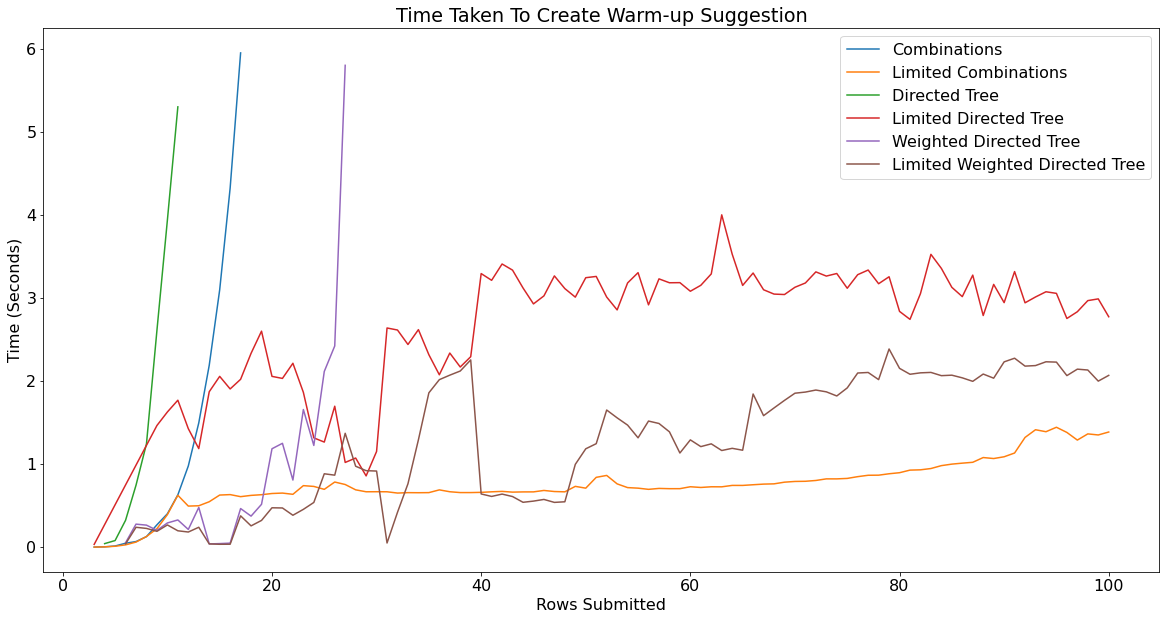

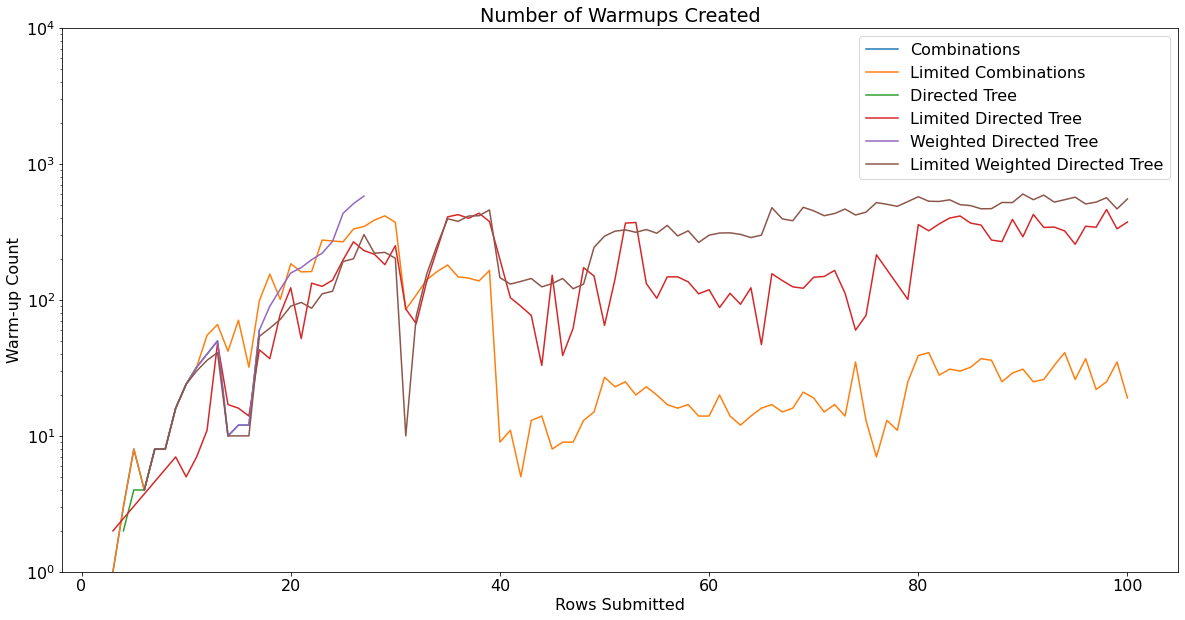

In [22]:
with open("../data/report/warmup_3_5.json", "r") as infile:
    high_dict = json.load(infile)

for func_n in high_dict.keys():
    plt.plot(high_dict[func_n]["n_moves"], high_dict[func_n]["t_avg"])
    
plt.title("Time Taken To Create Warm-up Suggestion")
plt.ylabel("Time (Seconds)")
plt.xlabel("Rows Submitted")
plt.legend(("Combinations", "Limited Combinations", "Directed Tree", "Limited Directed Tree", 
            "Weighted Directed Tree", "Limited Weighted Directed Tree"))
plt.show()

for func_n in high_dict.keys():
    plt.plot(high_dict[func_n]["n_moves"], high_dict[func_n]["n_warmups"])
    
plt.title("Number of Warmups Created")
plt.ylabel("Warm-up Count")
plt.xlabel("Rows Submitted")
plt.legend(("Combinations", "Limited Combinations", "Directed Tree", "Limited Directed Tree", 
            "Weighted Directed Tree", "Limited Weighted Directed Tree"))
plt.yscale("log")
plt.ylim(1, 10E3)
plt.show()

In [18]:
high_df = pd.DataFrame({"n_moves": list(range(1, 101))}).set_index("n_moves")

for n, mod in enumerate(["cw1_lim", "cw2_lim", "cw3_lim"], start=1):
    high_df[f"{n}_t_avg"] = None
    high_df[f"{n}_n_warmups"] = None
    high_df.loc[high_dict[mod]["n_moves"], f"{n}_t_avg"] = high_dict[mod]["t_avg"]
    high_df.loc[high_dict[mod]["n_moves"], f"{n}_n_warmups"] = high_dict[mod]["n_warmups"]
    
high_df = high_df.dropna()

In [24]:
print("Avg time diff f3 - f1:", round(np.mean(high_df["3_t_avg"] - high_df["1_t_avg"]), 2))
print("Avg time diff f3 - f2:", round(np.mean(high_df["3_t_avg"] - high_df["2_t_avg"]), 2))

Avg time diff f3 - f1: 0.52
Avg time diff f3 - f2: -1.39


In [25]:
print("Avg warmup count diff f3 - f1:", math.floor(np.mean(high_df["3_n_warmups"] - high_df["1_n_warmups"])))
print("Avg warmup count diff f3 - f2:", math.floor(np.mean(high_df["3_n_warmups"] - high_df["2_n_warmups"])))

Avg warmup count diff f3 - f1: 242
Avg warmup count diff f3 - f2: 123


In [121]:
low_dict = {
    "cw1": cross_validate_function(pat_df, create_warmup_1, min_moves=1, max_moves=3),
    "cw1_lim": cross_validate_function(pat_df, create_warmup_1_lim, min_moves=1, max_moves=3, max_seqs=1000),
    "cw2": cross_validate_function(pat_df, create_warmup_2, min_moves=1, max_moves=3),
    "cw2_lim": cross_validate_function(pat_df, create_warmup_2_lim, min_moves=1, max_moves=3, max_oe=7),
    "cw3": cross_validate_function(pat_df, create_warmup_3, min_moves=1, max_moves=3),
    "cw3_lim": cross_validate_function(pat_df, create_warmup_3_lim, min_moves=1, max_moves=3, max_oe=12)
}

with open("../data/report/warmup_1_3.json", 'w') as fp:
    json.dump(low_dict, fp)

[*] func validation started
[*] n_moves = 3 completed. t_avg = 0.0124
[*] n_moves = 4 completed. t_avg = 0.0212
[*] n_moves = 5 completed. t_avg = 0.0204
[*] n_moves = 6 completed. t_avg = 0.0264
[*] n_moves = 7 completed. t_avg = 0.0409
[*] n_moves = 8 completed. t_avg = 0.0632
[*] n_moves = 9 completed. t_avg = 0.0873
[*] n_moves = 10 completed. t_avg = 0.1182
[*] n_moves = 11 completed. t_avg = 0.1549
[*] n_moves = 12 completed. t_avg = 0.1991
[*] n_moves = 13 completed. t_avg = 0.2441
[*] n_moves = 14 completed. t_avg = 0.3086
[*] n_moves = 15 completed. t_avg = 0.3747
[*] n_moves = 16 completed. t_avg = 0.462
[*] n_moves = 17 completed. t_avg = 0.5637
[*] n_moves = 18 completed. t_avg = 0.6812
[*] n_moves = 19 completed. t_avg = 0.7678
[*] n_moves = 20 completed. t_avg = 0.8669
[*] n_moves = 21 completed. t_avg = 1.0035
[*] n_moves = 22 completed. t_avg = 1.1809
[*] n_moves = 23 completed. t_avg = 1.3153
[*] n_moves = 24 completed. t_avg = 1.5075
[*] n_moves = 25 completed. t_avg 

[*] n_moves = 67 failed.
[*] n_moves = 68 failed.
[*] n_moves = 69 failed.
[*] n_moves = 70 failed.
[*] n_moves = 71 failed.
[*] n_moves = 71 completed. t_avg = 1.0397
[*] n_moves = 72 failed.
[*] n_moves = 73 failed.
[*] n_moves = 74 completed. t_avg = 1.0272
[*] n_moves = 75 failed.
[*] n_moves = 76 failed.
[*] n_moves = 77 failed.
[*] n_moves = 78 failed.
[*] n_moves = 79 failed.
[*] n_moves = 80 failed.
[*] n_moves = 80 completed. t_avg = 1.0308
[*] n_moves = 81 failed.
[*] n_moves = 81 completed. t_avg = 1.2366
[*] n_moves = 82 failed.
[*] n_moves = 83 failed.
[*] n_moves = 83 completed. t_avg = 1.161
[*] n_moves = 84 failed.
[*] n_moves = 85 failed.
[*] n_moves = 85 completed. t_avg = 1.0511
[*] n_moves = 86 completed. t_avg = 1.0236
[*] n_moves = 87 failed.
[*] n_moves = 88 failed.
[*] n_moves = 88 completed. t_avg = 1.0224
[*] n_moves = 89 completed. t_avg = 0.9592
[*] n_moves = 90 failed.
[*] n_moves = 91 completed. t_avg = 1.0407
[*] n_moves = 92 failed.
[*] n_moves = 93 fail

[*] n_moves = 62 completed. t_avg = 0.3609
[*] n_moves = 63 completed. t_avg = 0.3639
[*] n_moves = 64 completed. t_avg = 0.3599
[*] n_moves = 65 completed. t_avg = 0.3624
[*] n_moves = 66 completed. t_avg = 0.5345
[*] n_moves = 67 completed. t_avg = 0.545
[*] n_moves = 68 completed. t_avg = 0.5412
[*] n_moves = 69 completed. t_avg = 0.5339
[*] n_moves = 70 completed. t_avg = 0.54
[*] n_moves = 71 completed. t_avg = 0.5427
[*] n_moves = 72 completed. t_avg = 0.5352
[*] n_moves = 73 completed. t_avg = 0.5417
[*] n_moves = 74 completed. t_avg = 0.5324
[*] n_moves = 75 completed. t_avg = 0.5375
[*] n_moves = 76 completed. t_avg = 0.5364
[*] n_moves = 77 completed. t_avg = 0.539
[*] n_moves = 78 completed. t_avg = 0.5322
[*] n_moves = 79 completed. t_avg = 0.7144
[*] n_moves = 80 completed. t_avg = 0.72
[*] n_moves = 81 completed. t_avg = 0.72
[*] n_moves = 82 completed. t_avg = 0.7123
[*] n_moves = 83 completed. t_avg = 0.722
[*] n_moves = 84 completed. t_avg = 0.7261
[*] n_moves = 85 com

In [125]:
with open("../data/report/warmup_1_3.json", 'w') as fp:
    json.dump(low_dict, fp)

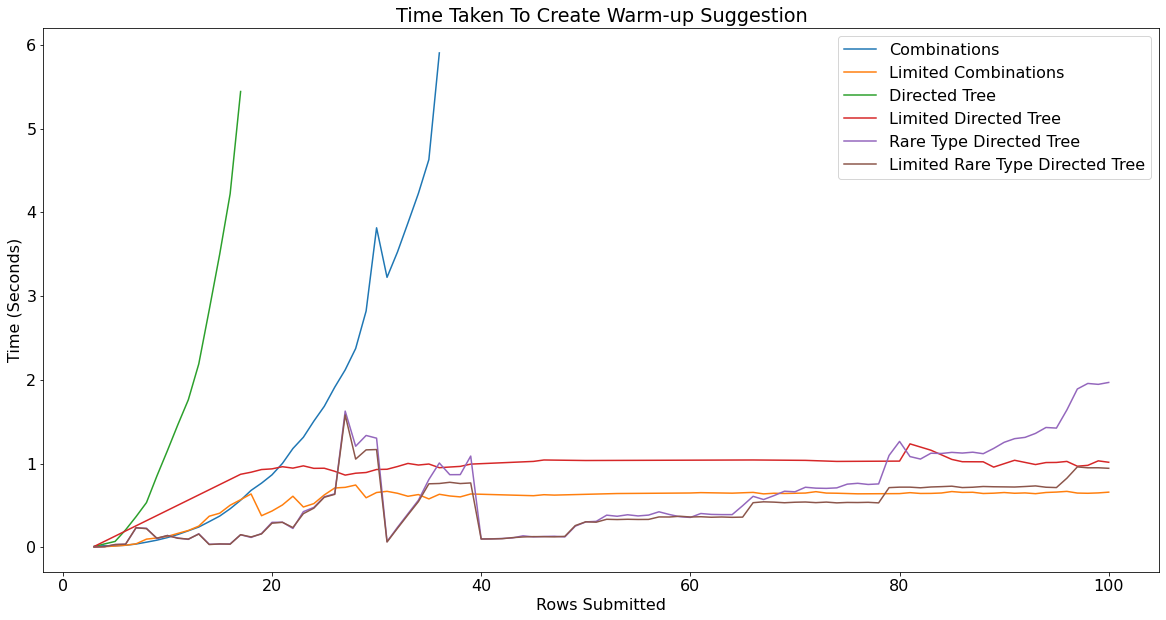

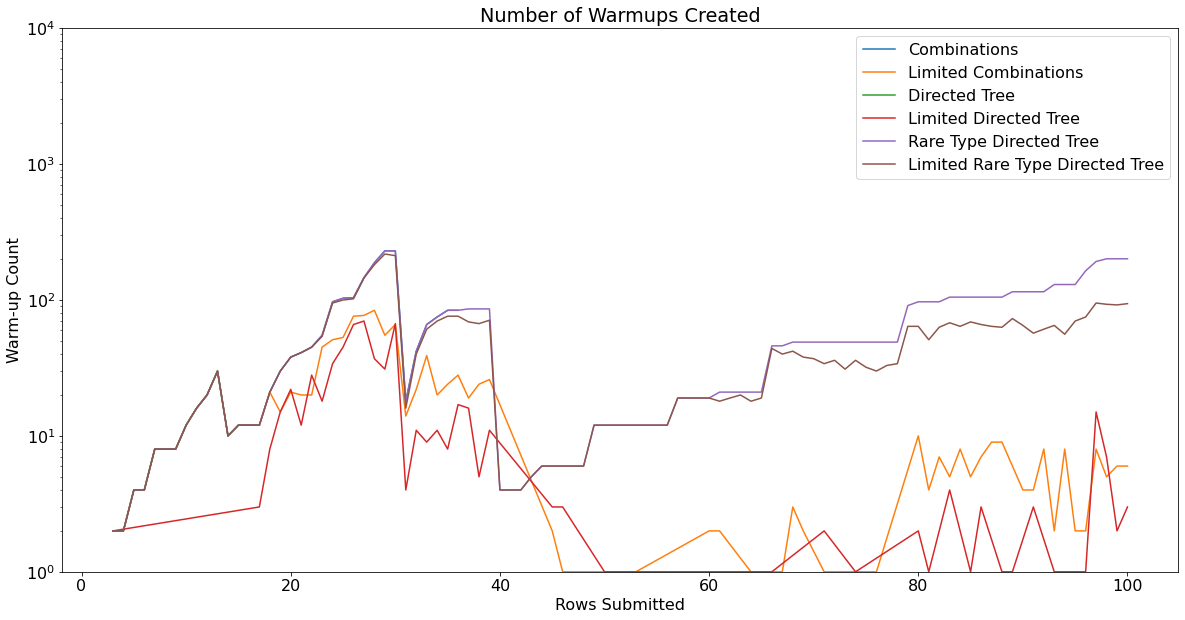

In [128]:
with open("../data/report/warmup_1_3.json", "r") as infile:
    low_dict = json.load(infile)
    
for func_n in low_dict.keys():
    plt.plot(low_dict[func_n]["n_moves"], low_dict[func_n]["t_avg"])
    
plt.title("Time Taken To Create Warm-up Suggestion")
plt.ylabel("Time (Seconds)")
plt.xlabel("Rows Submitted")
plt.legend(("Combinations", "Limited Combinations", "Directed Tree", "Limited Directed Tree", 
            "Rare Type Directed Tree", "Limited Rare Type Directed Tree"))
plt.show()

for func_n in low_dict.keys():
    plt.plot(low_dict[func_n]["n_moves"], low_dict[func_n]["n_warmups"])
    
plt.title("Number of Warmups Created")
plt.ylabel("Warm-up Count")
plt.xlabel("Rows Submitted")
plt.legend(("Combinations", "Limited Combinations", "Directed Tree", "Limited Directed Tree", 
            "Rare Type Directed Tree", "Limited Rare Type Directed Tree"))
plt.yscale("log")
plt.ylim(1, 10E3)
plt.show()